In [17]:
import pandas as pd

# Load customer and transaction data
customers = pd.read_csv('Customers.csv')
transactions = pd.read_csv('Transactions.csv')

# Merge customer profile data with transaction data
customer_data = pd.merge(customers, transactions, on='CustomerID', how='left')

# Inspect the merged data
print(customer_data.head())


  CustomerID      CustomerName         Region  SignupDate TransactionID  \
0      C0001  Lawrence Carroll  South America  2022-07-10        T00015   
1      C0001  Lawrence Carroll  South America  2022-07-10        T00932   
2      C0001  Lawrence Carroll  South America  2022-07-10        T00085   
3      C0001  Lawrence Carroll  South America  2022-07-10        T00445   
4      C0001  Lawrence Carroll  South America  2022-07-10        T00436   

  ProductID      TransactionDate  Quantity  TotalValue   Price  
0      P054  2024-01-19 03:12:55       2.0      114.60   57.30  
1      P022  2024-09-17 09:01:18       3.0      412.62  137.54  
2      P096  2024-04-08 00:01:00       2.0      614.94  307.47  
3      P083  2024-05-07 03:11:44       2.0      911.44  455.72  
4      P029  2024-11-02 17:04:16       3.0     1300.92  433.64  


**Step 2: Data Cleaning**

Handling Missing Values in customer_data (Customers.csv)

In [18]:
import numpy as np

# Separate numeric and non-numeric columns
numeric_columns = customer_data.select_dtypes(include=[np.number]).columns
categorical_columns = customer_data.select_dtypes(exclude=[np.number]).columns

# Fill missing values in numeric columns with the median
customer_data[numeric_columns] = customer_data[numeric_columns].fillna(customer_data[numeric_columns].median())

# Fill missing values in categorical columns with the mode (most frequent value)
for column in categorical_columns:
    customer_data[column] = customer_data[column].fillna(customer_data[column].mode()[0])

# Check if there are any missing values left
print(customer_data.isnull().sum())



CustomerID         0
CustomerName       0
Region             0
SignupDate         0
TransactionID      0
ProductID          0
TransactionDate    0
Quantity           0
TotalValue         0
Price              0
dtype: int64


**Handling Missing Values in transactions (Transactions.csv)**

In [19]:
# Separate numeric and non-numeric columns in transactions data
numeric_columns_trans = transactions.select_dtypes(include=[np.number]).columns
categorical_columns_trans = transactions.select_dtypes(exclude=[np.number]).columns

# Fill missing values in numeric columns with the median
transactions[numeric_columns_trans] = transactions[numeric_columns_trans].fillna(transactions[numeric_columns_trans].median())

# Fill missing values in categorical columns with the mode (most frequent value)
for column in categorical_columns_trans:
    transactions[column] = transactions[column].fillna(transactions[column].mode()[0])

# Check if there are any missing values left
print(transactions.isnull().sum())


TransactionID      0
CustomerID         0
ProductID          0
TransactionDate    0
Quantity           0
TotalValue         0
Price              0
dtype: int64


In [21]:
# Print the column names in customer_data
print(customer_data.columns)


Index(['CustomerID', 'CustomerName', 'Region', 'SignupDate', 'TransactionID',
       'ProductID', 'TransactionDate', 'Quantity', 'TotalValue', 'Price'],
      dtype='object')


In [22]:
# Assuming customer_data and transactions are loaded already

# Step 1: Calculate TotalSpend, NumTransactions, and AvgTransactionValue for each customer

# Group transactions by CustomerID and aggregate
customer_features = transactions.groupby('CustomerID').agg(
    TotalSpend=('TotalValue', 'sum'),  # Sum of TotalValue for each customer
    NumTransactions=('TransactionID', 'nunique'),  # Count of unique transactions per customer
    AvgTransactionValue=('TotalValue', 'mean')  # Mean transaction value
).reset_index()

# Merge the features with the customer_data dataframe
customer_data = customer_data.merge(customer_features, on='CustomerID', how='left')

# Check the newly created features
print(customer_data.head())


  CustomerID      CustomerName         Region  SignupDate TransactionID  \
0      C0001  Lawrence Carroll  South America  2022-07-10        T00015   
1      C0001  Lawrence Carroll  South America  2022-07-10        T00932   
2      C0001  Lawrence Carroll  South America  2022-07-10        T00085   
3      C0001  Lawrence Carroll  South America  2022-07-10        T00445   
4      C0001  Lawrence Carroll  South America  2022-07-10        T00436   

  ProductID      TransactionDate  Quantity  TotalValue   Price  TotalSpend  \
0      P054  2024-01-19 03:12:55       2.0      114.60   57.30     3354.52   
1      P022  2024-09-17 09:01:18       3.0      412.62  137.54     3354.52   
2      P096  2024-04-08 00:01:00       2.0      614.94  307.47     3354.52   
3      P083  2024-05-07 03:11:44       2.0      911.44  455.72     3354.52   
4      P029  2024-11-02 17:04:16       3.0     1300.92  433.64     3354.52   

   NumTransactions  AvgTransactionValue  
0              5.0              670.90

In [24]:
# Handle missing values by filling with the median
# Handle missing values by filling with the median for numeric columns only
numeric_columns = customer_data.select_dtypes(include=[np.number]).columns
customer_data[numeric_columns] = customer_data[numeric_columns].fillna(customer_data[numeric_columns].median())


In [25]:
# Select relevant numeric features for clustering
features = customer_data[['TotalSpend', 'NumTransactions', 'AvgTransactionValue']]

# Check if the features are numeric and ready for clustering
print(features.head())


   TotalSpend  NumTransactions  AvgTransactionValue
0     3354.52              5.0              670.904
1     3354.52              5.0              670.904
2     3354.52              5.0              670.904
3     3354.52              5.0              670.904
4     3354.52              5.0              670.904


In [26]:
from sklearn.preprocessing import StandardScaler

# Normalize/Standardize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Check the scaled features
print(scaled_features[:5])


[[-0.40908369 -0.46358807 -0.08879729]
 [-0.40908369 -0.46358807 -0.08879729]
 [-0.40908369 -0.46358807 -0.08879729]
 [-0.40908369 -0.46358807 -0.08879729]
 [-0.40908369 -0.46358807 -0.08879729]]


In [27]:
from sklearn.cluster import KMeans

# Apply KMeans clustering
num_clusters = 5  # You can adjust this value
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
customer_data['Cluster'] = kmeans.fit_predict(scaled_features)

# View the first few rows with the assigned clusters
print(customer_data[['CustomerID', 'Cluster']].head())


  CustomerID  Cluster
0      C0001        4
1      C0001        4
2      C0001        4
3      C0001        4
4      C0001        4


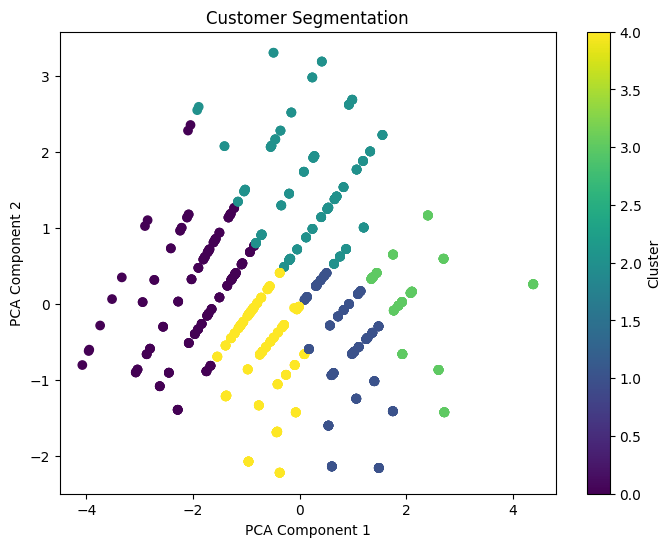

In [28]:
import matplotlib.pyplot as plt

# Reduce the dimensions to 2D for visualization (e.g., using PCA)
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca_components = pca.fit_transform(scaled_features)

# Plot the clusters
plt.figure(figsize=(8, 6))
plt.scatter(pca_components[:, 0], pca_components[:, 1], c=customer_data['Cluster'], cmap='viridis')
plt.title("Customer Segmentation")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(label='Cluster')
plt.show()


  Davies-Bouldin Index (DBI): A lower DBI indicates better-defined clusters. If DBI is high, the clusters are more overlapping or poorly separated.

  Silhouette Score: This score ranges from -1 to 1. A value closer to 1 indicates that the clusters are well-separated, while a negative value means that samples might have been assigned to the wrong cluster.

  Inertia: This shows how compact the clusters are. A lower inertia indicates that the points in the cluster are closer to the center, meaning the clustering is more effective.

In [31]:


from sklearn.metrics import davies_bouldin_score

# Calculate Davies-Bouldin Index (DBI)
dbi = davies_bouldin_score(scaled_features, customer_data['Cluster'])
print(f"Davies-Bouldin Index (DBI): {dbi}")



Davies-Bouldin Index (DBI): 1.043903852758651


In [32]:
from sklearn.metrics import silhouette_score

# Calculate Silhouette Score
sil_score = silhouette_score(scaled_features, customer_data['Cluster'])
print(f"Silhouette Score: {sil_score}")


Silhouette Score: 0.31077749141968347


In [33]:
# Get the inertia (sum of squared distances to centroids)
inertia = kmeans.inertia_
print(f"Inertia: {inertia}")


Inertia: 858.0675448847275


Davies-Bouldin Index (DBI): 1.043903852758651
Silhouette Score: 0.31077749141968347
Inertia: 858.0675448847275


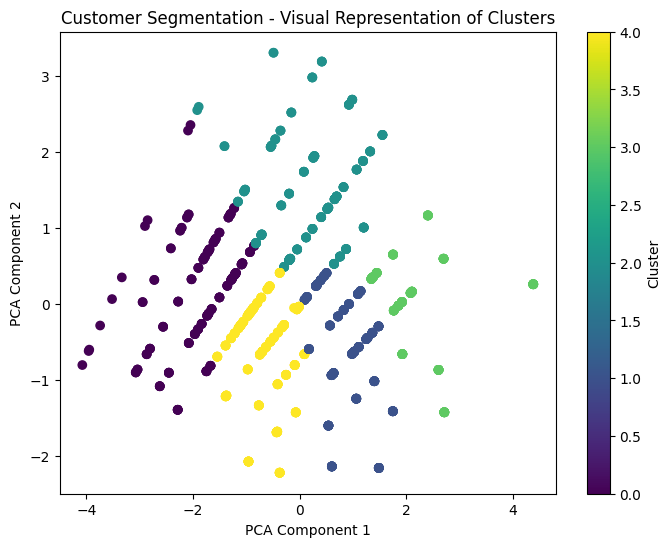

In [34]:
# Step 1: Perform KMeans clustering and assign cluster labels
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import davies_bouldin_score, silhouette_score

# Select features for clustering
features = customer_data[['TotalSpend', 'NumTransactions', 'AvgTransactionValue']]

# Normalize/Standardize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Apply KMeans clustering
num_clusters = 5  # You can adjust this value
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
customer_data['Cluster'] = kmeans.fit_predict(scaled_features)

# Step 2: Calculate evaluation metrics
# Davies-Bouldin Index (DBI)
dbi = davies_bouldin_score(scaled_features, customer_data['Cluster'])
print(f"Davies-Bouldin Index (DBI): {dbi}")

# Silhouette Score
sil_score = silhouette_score(scaled_features, customer_data['Cluster'])
print(f"Silhouette Score: {sil_score}")

# Inertia (Within-cluster sum of squares)
inertia = kmeans.inertia_
print(f"Inertia: {inertia}")

# Step 3: Visualize the clusters (PCA for 2D visualization)
pca = PCA(n_components=2)
pca_components = pca.fit_transform(scaled_features)

# Plot the clusters
plt.figure(figsize=(8, 6))
plt.scatter(pca_components[:, 0], pca_components[:, 1], c=customer_data['Cluster'], cmap='viridis')
plt.title("Customer Segmentation - Visual Representation of Clusters")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(label='Cluster')
plt.show()
